In [1]:
#%% imports
from scipy.io import loadmat
import pandas as pd
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.size"] = 40
import seaborn as sns
import pingouin as pg
from gridfunctions import *
from itertools import compress
import scipy.stats as stats
import math
import os
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from itertools import combinations 
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_ind
sns.set(style="whitegrid", font_scale = 5)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/denislan/opt/anaconda3/envs/dl/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [4]:
#load neuron_classes.csv
df_neuron = pd.read_csv('neuron_classes.csv')



In [5]:
df_neuron['neuron_classes'] = [x.capitalize() for x in df_neuron['neuron_classes']]
temp = df_neuron.groupby(['modelnum', 'cluster'])['neuron_classes'].value_counts().unstack().fillna(0).reset_index()
# df_neuron['neuron_classes'] =
temp = temp[temp['cluster'] < 3]

temp = temp.melt(id_vars = ['modelnum', 'cluster'], value_vars = ['Spatial', 'Conjunctive', 'Landmark', 'None'])
temp['value'] = temp['value']/10
print(temp)

#add values for pooled across clusters
temp2 = df_neuron.groupby(['modelnum'])['neuron_classes'].value_counts().unstack().fillna(0).reset_index()
temp2 = temp2.melt(id_vars = ['modelnum'], value_vars = ['Spatial', 'Conjunctive', 'Landmark', 'None'])
temp2['cluster'] = -1
temp2['value'] = temp2['value']/100
temp = pd.concat([temp, temp2])
print(temp)
temp['value'] = temp['value']*100


     modelnum  cluster neuron_classes  value
0           1        0        Spatial    0.6
1           1        1        Spatial    0.4
2           1        2        Spatial    0.5
3           2        0        Spatial    0.9
4           2        1        Spatial    0.5
..        ...      ...            ...    ...
235        19        1           None    0.0
236        19        2           None    0.0
237        20        0           None    0.1
238        20        1           None    0.0
239        20        2           None    0.0

[240 rows x 4 columns]
    modelnum  cluster neuron_classes  value
0          1        0        Spatial   0.60
1          1        1        Spatial   0.40
2          1        2        Spatial   0.50
3          2        0        Spatial   0.90
4          2        1        Spatial   0.50
..       ...      ...            ...    ...
75        16       -1           None   0.07
76        17       -1           None   0.04
77        18       -1           None   0

/var/folders/0y/gjx_6j1j6b74t37j8v49ws6m0000gs/T/ipykernel_97850/3062722747.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2['value'] = [temp2['value'].iloc[i] + mean_temp1['value'][mean_temp1['cluster'] == temp2['cluster'].iloc[i]].iloc[0] for i in range(temp2.shape[0])]
/var/folders/0y/gjx_6j1j6b74t37j8v49ws6m0000gs/T/ipykernel_97850/3062722747.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp3['value'] = [temp3['value'].iloc[i] + mean_temp2['value'][mean_temp2['cluster'] == temp3['clust

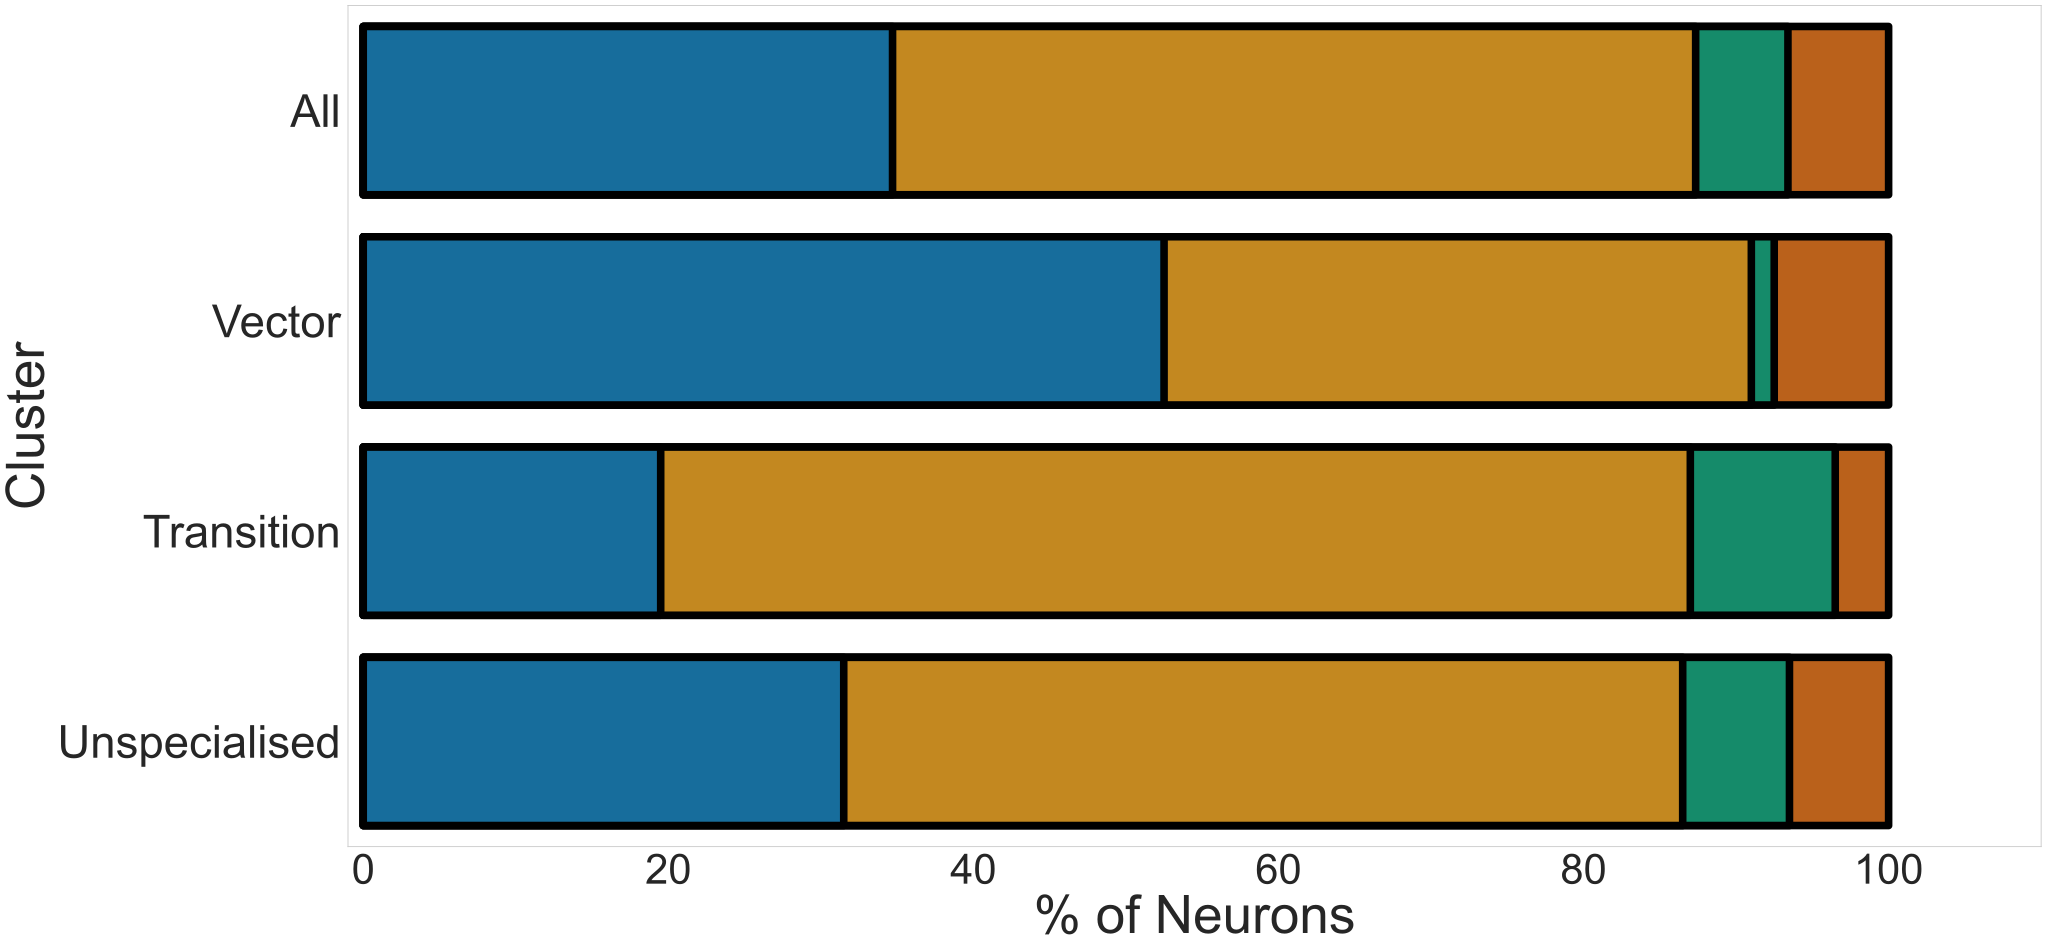

In [6]:
#stacked bar chart
fig = plt.figure(figsize = (40,20))
# temp_pivot = temp.pivot_table(index = ['modelnum', 'cluster'], columns = 'neuron_classes', values = 'value').reset_index()
# temp_pivot_mean = temp_pivot.groupby('cluster').mean().reset_index()
# temp_pivot_mean.plot.bar(stacked = True, x = 'cluster', y = ['spatial', 'conjunctive', 'landmark', 'none'], color = palette, width = 0.7)

# #add error bars
# temp_pivot_std = temp_pivot.groupby('cluster').std().reset_index()
# for i in range(4):
#     plt.errorbar(temp_pivot_mean['cluster'], temp_pivot_mean.iloc[:,i+1], yerr = temp_pivot_std.iloc[:,i+1], fmt = 'none', ecolor = 'black', capsize = 10, elinewidth = 10)
palette = sns.color_palette('colorblind')

temp1 = temp[temp['neuron_classes'] == 'Spatial']


temp2 = temp[temp['neuron_classes'] == 'Conjunctive']
mean_temp1 = temp1.groupby('cluster')['value'].mean().reset_index()
temp2['value'] = [temp2['value'].iloc[i] + mean_temp1['value'][mean_temp1['cluster'] == temp2['cluster'].iloc[i]].iloc[0] for i in range(temp2.shape[0])]

temp3 = temp[temp['neuron_classes'] == 'Landmark']
mean_temp2 = temp2.groupby('cluster')['value'].mean().reset_index()
temp3['value'] = [temp3['value'].iloc[i] + mean_temp2['value'][mean_temp2['cluster'] == temp3['cluster'].iloc[i]].iloc[0] for i in range(temp3.shape[0])]

temp4 = temp[temp['neuron_classes'] == 'None']
mean_temp3 = temp3.groupby('cluster')['value'].mean().reset_index()
temp4['value'] = [temp4['value'].iloc[i] + mean_temp3['value'][mean_temp3['cluster'] == temp4['cluster'].iloc[i]].iloc[0] for i in range(temp4.shape[0])]


g4 = sns.barplot(y = 'cluster', x = 'value', data = temp4, color=palette[3], ci = 68, errwidth = 0, edgecolor = 'black', linewidth = 10, errcolor='black', alpha = 1, orient = 'h')
g3 = sns.barplot(y = 'cluster', x = 'value', data = temp3, color=palette[2], ci = 68, errwidth = 0, edgecolor = 'black', linewidth = 10, errcolor='black', alpha = 1, orient = 'h')

g2 = sns.barplot(y = 'cluster', x = 'value', data = temp2, color=palette[1], ci = 68, errwidth = 0, edgecolor = 'black', linewidth = 10, errcolor='black', alpha = 1, orient = 'h')
g1 = sns.barplot(y = 'cluster', x = 'value', data = temp1, color=palette[0], ci = 68, errwidth = 0, edgecolor = 'black', linewidth = 10, errcolor='black', alpha = 1, orient = 'h')

g1.set_ylabel('Cluster', fontsize = 70)
#multiply yticks by 100
# xticks = g1.get_xticks()
# g1.set_xticklabels([0, 20, 40, 60, 80, 100], fontsize = 60)
g1.set_xlabel('% of Neurons', fontsize = 70)
g1.set_yticklabels(['All', 'Vector', 'Transition', 'Unspecialised'], fontsize = 60)

#set xlim
g1.set_xlim(-0.005 * 200, 110)

#no grid lines
g1.grid(False)

# #add error bars, with y offset for each cluster
# temp1_std = temp1.groupby('cluster')['value'].std().reset_index()
# temp2_std = temp2.groupby('cluster')['value'].std().reset_index()
# temp3_std = temp3.groupby('cluster')['value'].std().reset_index()
# temp4_std = temp4.groupby('cluster')['value'].std().reset_index()

# # Calculate standard error for each group
# temp1_se = temp1.groupby('cluster')['value'].apply(lambda x: np.std(x) / np.sqrt(len(x))).reset_index(name='value')
# temp2_se = temp2.groupby('cluster')['value'].apply(lambda x: np.std(x) / np.sqrt(len(x))).reset_index(name='value')
# temp3_se = temp3.groupby('cluster')['value'].apply(lambda x: np.std(x) / np.sqrt(len(x))).reset_index(name='value')
# temp4_se = temp4.groupby('cluster')['value'].apply(lambda x: np.std(x) / np.sqrt(len(x))).reset_index(name='value')

# temp1_mean = temp1.groupby('cluster')['value'].mean().reset_index()
# temp2_mean = temp2.groupby('cluster')['value'].mean().reset_index()
# temp3_mean = temp3.groupby('cluster')['value'].mean().reset_index()
# temp4_mean = temp4.groupby('cluster')['value'].mean().reset_index()

# y_vals = np.array([-1, 0, 1, 2])
# for i in range(4):
#     plt.errorbar(temp1_mean['value'][i], i - 0.09, xerr = temp1_se['value'][i], fmt = 'none', ecolor = 'black', capsize = 0, elinewidth = 10)
#     plt.errorbar(temp2_mean['value'][i], i - 0.03, xerr = temp2_se['value'][i], fmt = 'none', ecolor = 'black', capsize = 0, elinewidth = 10)
#     plt.errorbar(temp3_mean['value'][i], i + 0.03, xerr = temp3_se['value'][i], fmt = 'none', ecolor = 'black', capsize = 0, elinewidth = 10)
#     plt.errorbar(temp4_mean['value'][i], i + 0.09, xerr = temp4_se['value'][i], fmt = 'none', ecolor = 'black', capsize = 0, elinewidth = 10)

In [7]:
#chi square test 
temp = df_neuron.groupby(['cluster'])['neuron_classes'].value_counts().unstack().fillna(0).reset_index()
temp = temp[temp['cluster'] < 3]
print(temp)

from scipy.stats import chi2_contingency
chi2, p, dof, ex = chi2_contingency(temp[['Spatial', 'Conjunctive', 'Landmark', 'None']])
print(p)
print(chi2)
print(dof)
#adjusted residuals
from statsmodels.stats.contingency_tables import Table
table = Table(temp[['Spatial', 'Conjunctive', 'Landmark', 'None']])
res = table.resid_pearson
print(res)

#p-value for each cell
pvals = res.applymap(lambda x: stats.norm.sf(abs(x))*2)
print(pvals)


neuron_classes  cluster  Conjunctive  Landmark  None  Spatial
0                     0           77         3    15      105
1                     1          135        19     7       39
2                     2          110        14    13       63
1.5646505927869545e-11
62.2561076604555
6
neuron_classes   Spatial  Conjunctive  Landmark     None
0               4.333891    -2.927877 -2.598076  0.97590
1              -3.611576     2.670481  2.020726 -1.36626
2              -0.722315     0.257396  0.577350  0.39036
neuron_classes   Spatial  Conjunctive  Landmark      None
0               0.000015     0.003413  0.009375  0.329114
1               0.000304     0.007574  0.043308  0.171857
2               0.470101     0.796873  0.563703  0.696270


In [8]:
#load lineardecoding.csv
df_lineardecoding = pd.read_csv('lineardecoding.csv')

In [11]:
oldx = df_lineardecoding[df_lineardecoding['value'] == 'oldx'].reset_index(drop=True)
#add 'x' to column names
oldx.columns = [str(col) + '_x' for col in oldx.columns]
oldy = df_lineardecoding[df_lineardecoding['value'] == 'oldy'].reset_index(drop=True)
#add 'y' to column names
oldy.columns = [str(col) + '_y' for col in oldy.columns]

goalx = df_lineardecoding[df_lineardecoding['value'] == 'goalx'].reset_index(drop=True)
#add 'x' to column names
goalx.columns = [str(col) + '_goalx' for col in goalx.columns]
goaly = df_lineardecoding[df_lineardecoding['value'] == 'goaly'].reset_index(drop=True)
#add 'y' to column names
goaly.columns = [str(col) + '_goaly' for col in goaly.columns]


df_combined = pd.concat([oldx, oldy, goalx, goaly], axis = 1)
df_combined['euclidean_error_old'] = np.sqrt((df_combined['error_x']**2) + (df_combined['error_y']**2))
df_combined['euclidean_error_goal'] = np.sqrt((df_combined['error_goalx']**2) + (df_combined['error_goaly']**2))
print(df_combined)

         Unnamed: 0_x  actual_x  decoded_x   error_x value_x  cluster_x  \
0                   0         6   4.277192  1.722808    oldx          0   
1                   1         2   3.006576  1.006576    oldx          0   
2                   2         1   3.517516  2.517516    oldx          0   
3                   3         5   3.845227  1.154773    oldx          0   
4                   4         3   2.879369  0.120631    oldx          0   
...               ...       ...        ...       ...     ...        ...   
1091983         56365         4   3.966985  0.033015    oldx          2   
1091984         56366         3   2.602796  0.397204    oldx          2   
1091985         56367         6   4.497168  1.502831    oldx          2   
1091986         56368         6   3.836214  2.163786    oldx          2   
1091987         56369         2   3.002011  1.002011    oldx          2   

         model_x  Unnamed: 0_y  actual_y  decoded_y  ...  model_goalx  \
0              1         5

     model_x  cluster_x                 value     error
0          1          0   euclidean_error_old  2.519734
1          1          1   euclidean_error_old  2.571574
2          1          2   euclidean_error_old  2.480825
3          2          0   euclidean_error_old  2.484745
4          2          1   euclidean_error_old  2.525124
..       ...        ...                   ...       ...
115       19          1  euclidean_error_goal  1.780328
116       19          2  euclidean_error_goal  1.987947
117       20          0  euclidean_error_goal  1.815124
118       20          1  euclidean_error_goal  1.919445
119       20          2  euclidean_error_goal  2.024207

[120 rows x 4 columns]


/var/folders/0y/gjx_6j1j6b74t37j8v49ws6m0000gs/T/ipykernel_97850/117162433.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  g = sns.pointplot(data = temp, x = 'value', y = 'error', hue = 'cluster_x',  palette = 'colorblind', ci = 95, dodge = 0.54, linestyles = 'none', markers = '_', scale = 10, errwidth = 20)
/Users/denislan/opt/anaconda3/envs/dl/lib/python3.11/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.00392156862745098, 0.45098039215686275, 0.6980392156862745)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/denislan/opt/anaconda3/envs/dl/lib/python3.11/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.8705882352941177, 0.5607843137254902, 0.0196078431372549)) for an unfilled marker ('_').  Matplotlib is 

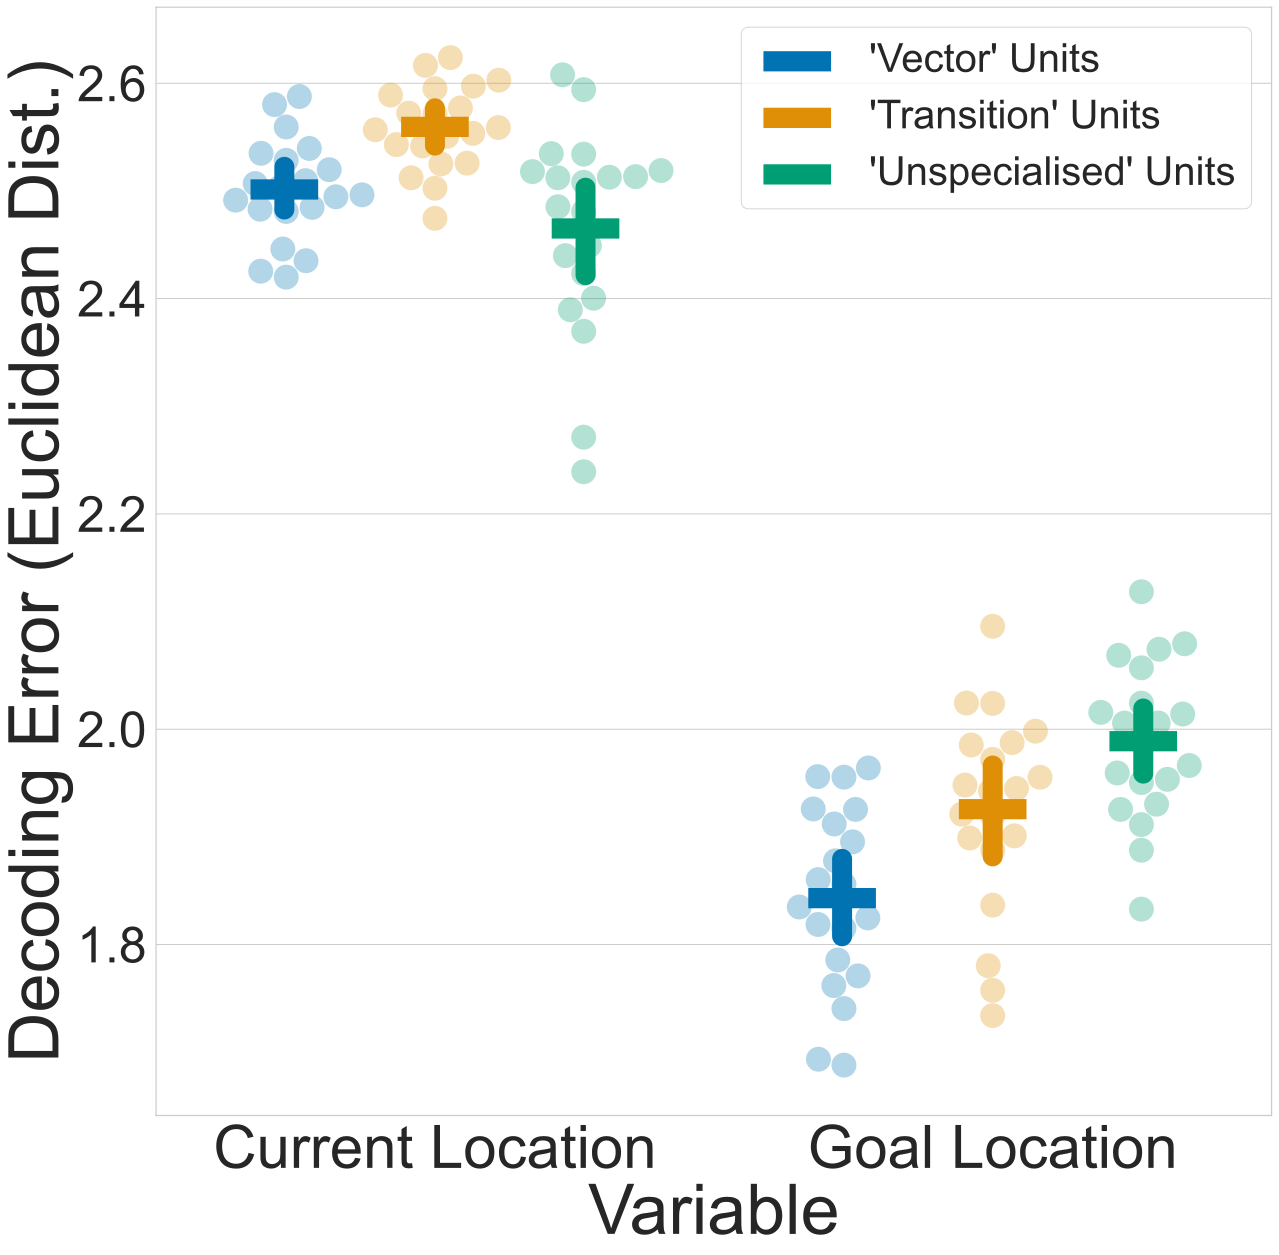

In [13]:
#plot error
temp = df_combined.groupby(['model_x', 'cluster_x'])[['euclidean_error_old', 'euclidean_error_goal']].mean().reset_index()
#pivot table
temp = pd.melt(temp, id_vars = ['model_x', 'cluster_x'], value_vars = ['euclidean_error_old', 'euclidean_error_goal'], var_name = 'value', value_name = 'error')
print(temp)
sns.set(style="whitegrid", font_scale = 7)
fig = plt.figure(figsize = (20,20))
g = sns.pointplot(data = temp, x = 'value', y = 'error', hue = 'cluster_x',  palette = 'colorblind', ci = 95, dodge = 0.54, linestyles = 'none', markers = '_', scale = 10, errwidth = 20)
g2 = sns.swarmplot(data = temp, x = 'value', y = 'error', hue = 'cluster_x',  alpha = .3,  size = 25, palette = 'colorblind', dodge = 0.4)
g2.set_xlabel('Variable', fontsize = 70)
g2.set_xticklabels(['Current Location', 'Goal Location'], fontsize = 60)
g2.set_ylabel('Decoding Error (Euclidean Dist.)', fontsize = 70)
#set yticklabel fontsize
yticks = g2.get_yticks()
yticks = np.around(yticks, decimals = 1)
g2.set_yticklabels(yticks, size = 50)
#set legend
g2.legend(loc = 'upper right', fontsize = 40, labels=['_', '_', '_',"'Vector' Units",'_', '_', '_',   "'Transition' Units", '_', '_', '_', "'Unspecialised' Units"])

In [15]:
#anova
 

#perform two-way ANOVA
temp = df_combined.groupby(['model_x', 'cluster_x'])[['euclidean_error_old', 'euclidean_error_goal']].mean().reset_index()
temp = pd.melt(temp, id_vars = ['model_x', 'cluster_x'], value_vars = ['euclidean_error_old', 'euclidean_error_goal'], var_name = 'value', value_name = 'error')
temp = temp[temp['value'] == 'euclidean_error_old'].groupby(['model_x', 'cluster_x'])['error'].mean().reset_index()
model = ols('error ~ C(cluster_x)', data = temp).fit()
anova_table = anova_lm(model, typ = 2)
print(anova_table)

#post-hoc t-tests with bonferroni correction

comparisons = list(combinations(temp['cluster_x'].unique(), 2))
p_values = []
t_stats = []
for g1, g2 in comparisons:
    temp1 = temp[temp['cluster_x'] == g1]['error']
    temp2 = temp[temp['cluster_x'] == g2]['error']
    p_values.append(ttest_ind(temp1, temp2)[1])
    t_stats.append(ttest_ind(temp1, temp2)[0])
    #degrees of freedom
    df = len(temp1) + len(temp2) - 2
    print(df)

reject, p_values_corrected, alphacSidak, alphacBonf = multipletests(p_values, alpha = 0.05, method = 'bonferroni')

for (g1, g2), p, p_corr, t in zip(comparisons, p_values, p_values_corrected, t_stats):
    print(f'{g1} vs {g2}: p-value = {p}, corrected p-value = {p_corr}')
    print(f't-statistic = {t}')
    print()

# #kruskal-wallis
# H, p = stats.kruskal(temp[temp['cluster_x'] == 0]['error'], temp[temp['cluster_x'] == 1]['error'], temp[temp['cluster_x'] == 2]['error'])
# print(H, p)

# #dunn's post-hoc
# from scikit_posthocs import posthoc_dunn
# p_values = posthoc_dunn(temp, val_col = 'error', group_col = 'cluster_x', p_adjust = 'bonferroni')
# print(p_values)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                sum_sq    df          F    PR(>F)
C(cluster_x)  0.090707   2.0  10.643193  0.000118
Residual      0.242892  57.0        NaN       NaN
38
38
38
0 vs 1: p-value = 0.00013207438691614315, corrected p-value = 0.00039622316074842945
t-statistic = -4.253747387313197

0 vs 2: p-value = 0.13464210626532472, corrected p-value = 0.4039263187959742
t-statistic = 1.5286154972681576

1 vs 2: p-value = 0.00020733978683975098, corrected p-value = 0.0006220193605192529
t-statistic = 4.103708273096271



In [16]:
#anova

#perform two-way ANOVA
temp = df_combined.groupby(['model_x', 'cluster_x'])[['euclidean_error_old', 'euclidean_error_goal']].mean().reset_index()
temp = pd.melt(temp, id_vars = ['model_x', 'cluster_x'], value_vars = ['euclidean_error_old', 'euclidean_error_goal'], var_name = 'value', value_name = 'error')
temp = temp[temp['value'] == 'euclidean_error_goal'].groupby(['model_x', 'cluster_x'])['error'].mean().reset_index()
model = ols('error ~ C(cluster_x)', data = temp).fit()
anova_table = anova_lm(model, typ = 2)
print(anova_table)

comparisons = list(combinations(temp['cluster_x'].unique(), 2))
p_values = []
t_stats = []
for g1, g2 in comparisons:
    temp1 = temp[temp['cluster_x'] == g1]['error']
    temp2 = temp[temp['cluster_x'] == g2]['error']
    p_values.append(ttest_ind(temp1, temp2)[1])
    t_stats.append(ttest_ind(temp1, temp2)[0])
    #degrees of freedom
    df = len(temp1) + len(temp2) - 2
    print(df)

reject, p_values_corrected, alphacSidak, alphacBonf = multipletests(p_values, alpha = 0.05, method = 'bonferroni')

for (g1, g2), p, p_corr, t in zip(comparisons, p_values, p_values_corrected, t_stats):
    print(f'{g1} vs {g2}: p-value = {p}, corrected p-value = {p_corr}')
    print(f't-statistic = {t}')
    print()

# #kruskal-wallis
# H, p = stats.kruskal(temp[temp['cluster_x'] == 0]['error'], temp[temp['cluster_x'] == 1]['error'], temp[temp['cluster_x'] == 2]['error'])
# print(H, p)

# #dunn's post-hoc
# from scikit_posthocs import posthoc_dunn
# p_values = posthoc_dunn(temp, val_col = 'error', group_col = 'cluster_x', p_adjust = 'bonferroni')
# print(p_values)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                sum_sq    df         F    PR(>F)
C(cluster_x)  0.213810   2.0  15.24214  0.000005
Residual      0.399785  57.0       NaN       NaN
38
38
38
0 vs 1: p-value = 0.0054538710467755104, corrected p-value = 0.016361613140326532
t-statistic = -2.947266684704747

0 vs 2: p-value = 9.785325776096034e-07, corrected p-value = 2.93559773282881e-06
t-statistic = -5.82854201481129

1 vs 2: p-value = 0.02139263090893825, corrected p-value = 0.06417789272681475
t-statistic = -2.400168896586228



In [17]:
#load logdecoding.csv
df_logdecoding = pd.read_csv('logdecoding.csv')

     model  cluster            value     error
0        1        0      adj_to_goal  0.384739
1        1        0  adj_to_landmark  0.310544
2        1        1      adj_to_goal  0.304696
3        1        1  adj_to_landmark  0.194876
4        1        2      adj_to_goal  0.429562
..     ...      ...              ...       ...
115     20        0  adj_to_landmark  0.394757
116     20        1      adj_to_goal  0.359960
117     20        1  adj_to_landmark  0.230087
118     20        2      adj_to_goal  0.392821
119     20        2  adj_to_landmark  0.280649

[120 rows x 4 columns]


/var/folders/0y/gjx_6j1j6b74t37j8v49ws6m0000gs/T/ipykernel_97850/4011545994.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  g = sns.pointplot(data = temp, x = 'value', y = 'error', hue = 'cluster',  palette = 'colorblind', ci = 95, dodge = 0.54, linestyles = 'none', markers = '_', scale = 10, errwidth = 20)
/Users/denislan/opt/anaconda3/envs/dl/lib/python3.11/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.00392156862745098, 0.45098039215686275, 0.6980392156862745)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/denislan/opt/anaconda3/envs/dl/lib/python3.11/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.8705882352941177, 0.5607843137254902, 0.0196078431372549)) for an unfilled marker ('_').  Matplotlib is i

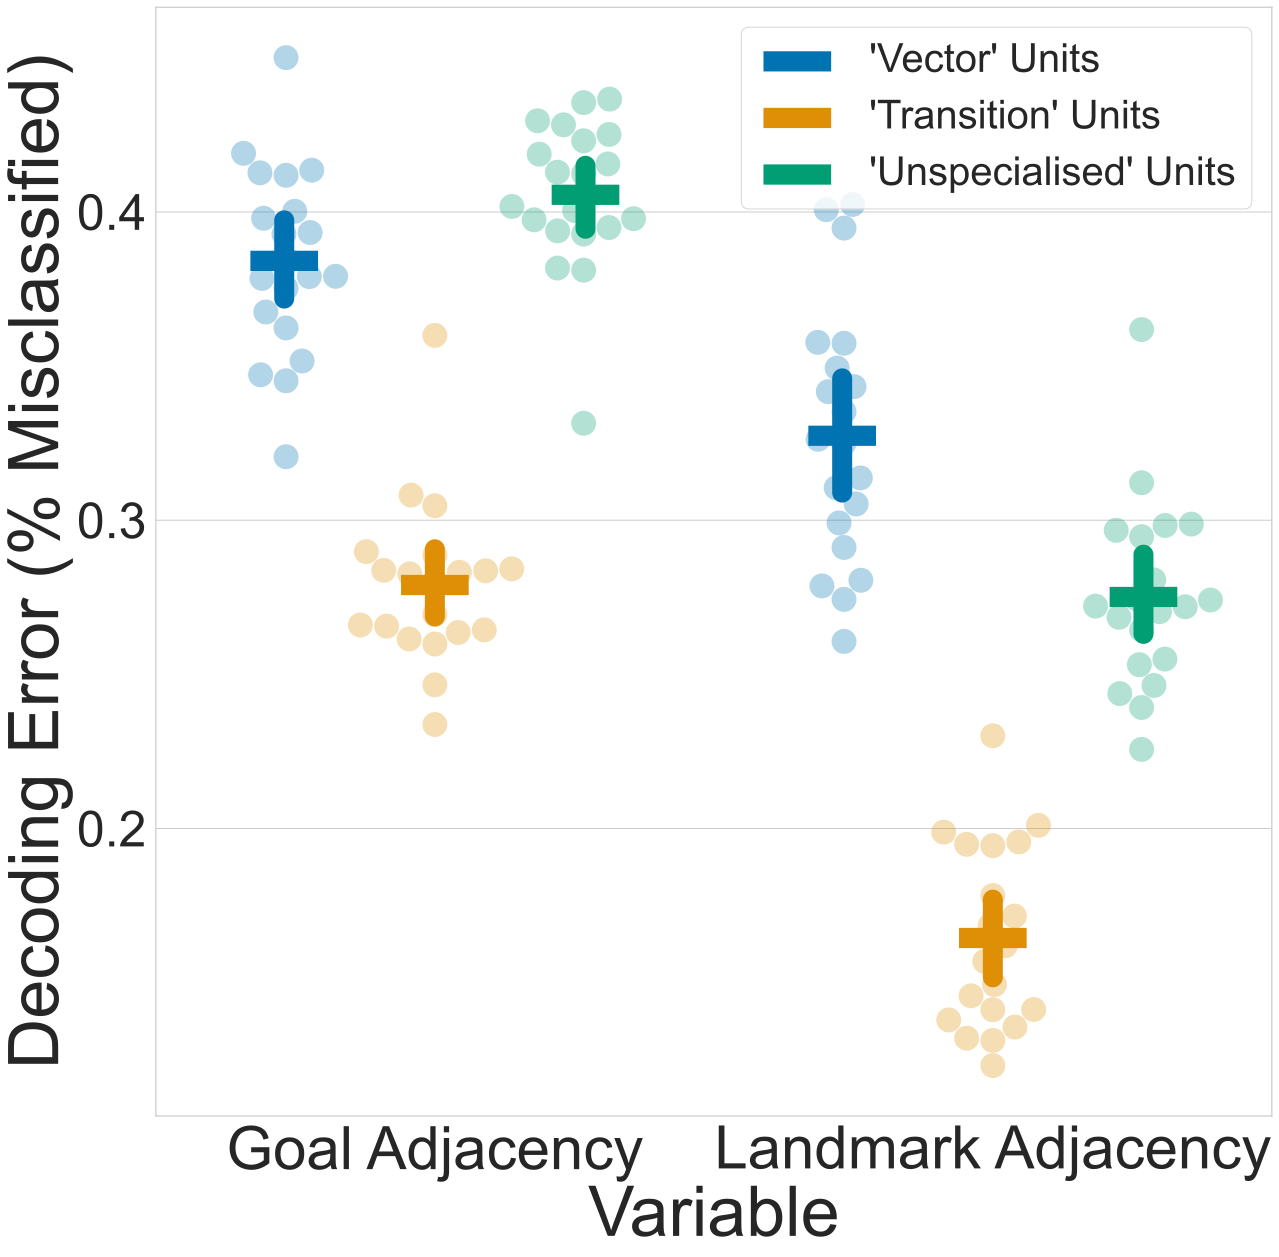

In [19]:
#plot error
temp = df_logdecoding[df_logdecoding['value'] != 'curr_at_landmark'].groupby(['model', 'cluster', 'value'])['error'].mean().reset_index()
print(temp)
sns.set(style="whitegrid", font_scale = 7)
fig = plt.figure(figsize = (20,20))
g = sns.pointplot(data = temp, x = 'value', y = 'error', hue = 'cluster',  palette = 'colorblind', ci = 95, dodge = 0.54, linestyles = 'none', markers = '_', scale = 10, errwidth = 20)
g2 = sns.swarmplot(data = temp, x = 'value', y = 'error', hue = 'cluster',  alpha = .3,  size = 25, palette = 'colorblind', dodge = 0.4)
g2.set_xlabel('Variable', fontsize = 70)
g2.set_xticklabels(['Goal Adjacency', 'Landmark Adjacency'], fontsize = 60)
g2.set_ylabel('Decoding Error (% Misclassified)', fontsize = 70)
#set yticklabel fontsize
yticks = g2.get_yticks()
yticks = np.around(yticks, decimals = 2)
g2.set_yticklabels(yticks, size = 50)
#set legend
g2.legend(loc = 'upper right', fontsize = 40, labels=['_', '_', '_',"'Vector' Units",'_', '_', '_',   "'Transition' Units", '_', '_', '_', "'Unspecialised' Units"])

In [20]:
#anova

#perform one-way ANOVA
# temp = df_logdecoding[df_logdecoding['value'] != 'curr_at_landmark'].groupby(['model', 'cluster', 'value'])['error'].mean().reset_index()
temp = df_logdecoding
temp = temp[temp['value'] == 'adj_to_goal'].groupby(['model', 'cluster'])['error'].mean().reset_index()

model = ols('error ~ C(cluster)', data = temp).fit()
anova_table = anova_lm(model, typ = 2)
print(anova_table)


comparisons = list(combinations(temp['cluster'].unique(), 2))
p_values = []
t_stats = []
for g1, g2 in comparisons:
    temp1 = temp[temp['cluster'] == g1]['error']
    temp2 = temp[temp['cluster'] == g2]['error']
    p_values.append(ttest_ind(temp1, temp2)[1])
    t_stats.append(ttest_ind(temp1, temp2)[0])
    #degrees of freedom
    df = len(temp1) + len(temp2) - 2
    print(df)

reject, p_values_corrected, alphacSidak, alphacBonf = multipletests(p_values, alpha = 0.05, method = 'bonferroni')

for (g1, g2), p, p_corr, t in zip(comparisons, p_values, p_values_corrected, t_stats):
    print(f'{g1} vs {g2}: p-value = {p}, corrected p-value = {p_corr}')
    print(f't-statistic = {t}')
    print()
    

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
              sum_sq    df           F        PR(>F)
C(cluster)  0.183586   2.0  125.209963  1.386983e-21
Residual    0.041787  57.0         NaN           NaN
38
38
38
0 vs 1: p-value = 3.395128349702488e-14, corrected p-value = 1.0185385049107464e-13
t-statistic = 11.72873489224818

0 vs 2: p-value = 0.01839940284550798, corrected p-value = 0.055198208536523935
t-statistic = -2.4635143165516986

1 vs 2: p-value = 2.538262457501539e-18, corrected p-value = 7.614787372504618e-18
t-statistic = -15.834685763814086



In [21]:
#anova

#perform one-way ANOVA
# temp = df_logdecoding[df_logdecoding['value'] != 'curr_at_landmark'].groupby(['model', 'cluster', 'value'])['error'].mean().reset_index()
temp = df_logdecoding
temp = temp[temp['value'] == 'adj_to_landmark'].groupby(['model', 'cluster'])['error'].mean().reset_index()

model = ols('error ~ C(cluster)', data = temp).fit()
anova_table = anova_lm(model, typ = 2)
print(anova_table)

#post-hoc t-tests with bonferroni correction


comparisons = list(combinations(temp['cluster'].unique(), 2))
p_values = []
t_stats = []
for g1, g2 in comparisons:
    temp1 = temp[temp['cluster'] == g1]['error']
    temp2 = temp[temp['cluster'] == g2]['error']
    p_values.append(ttest_ind(temp1, temp2)[1])
    t_stats.append(ttest_ind(temp1, temp2)[0])
    #degrees of freedom
    df = len(temp1) + len(temp2) - 2
    print(df)

reject, p_values_corrected, alphacSidak, alphacBonf = multipletests(p_values, alpha = 0.05, method = 'bonferroni')

for (g1, g2), p, p_corr, t in zip(comparisons, p_values, p_values_corrected, t_stats):
    print(f'{g1} vs {g2}: p-value = {p}, corrected p-value = {p_corr}')
    print(f't-statistic = {t}')
    print()
    
# #kruskal-wallis
# H, p = stats.kruskal(temp[temp['cluster'] == 0]['error'], temp[temp['cluster'] == 1]['error'], temp[temp['cluster'] == 2]['error'])
# print(H, p)

# #dunn's post-hoc
# from scikit_posthocs import posthoc_dunn
# p_values = posthoc_dunn(temp, val_col = 'error', group_col = 'cluster', p_adjust = 'bonferroni')
# print(p_values)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
              sum_sq    df           F        PR(>F)
C(cluster)  0.276736   2.0  116.355128  7.524248e-21
Residual    0.067784  57.0         NaN           NaN
38
38
38
0 vs 1: p-value = 9.695217174195521e-17, corrected p-value = 2.9085651522586566e-16
t-statistic = 14.161727035499261

0 vs 2: p-value = 5.8161169562861664e-05, corrected p-value = 0.00017448350868858498
t-statistic = 4.523115474742126

1 vs 2: p-value = 4.6126745784440053e-14, corrected p-value = 1.3838023735332016e-13
t-statistic = -11.60918621010571



In [22]:
#load df_ablated_all.h5
df_ablated = pd.read_hdf('df_ablated_all.h5')

HDF5ExtError: HDF5 error back trace

  File "H5F.c", line 620, in H5Fopen
    unable to open file
  File "H5VLcallback.c", line 3502, in H5VL_file_open
    failed to iterate over available VOL connector plugins
  File "H5PLpath.c", line 579, in H5PL__path_table_iterate
    can't iterate over plugins in plugin path '(null)'
  File "H5PLpath.c", line 620, in H5PL__path_table_iterate_process_path
    can't open directory: /Users/denislan/opt/anaconda3/envs/dl/lib/hdf5/plugin
  File "H5VLcallback.c", line 3351, in H5VL__file_open
    open failed
  File "H5VLnative_file.c", line 97, in H5VL__native_file_open
    unable to open file
  File "H5Fint.c", line 1999, in H5F_open
    unable to read root group
  File "H5Groot.c", line 228, in H5G_mkroot
    can't check if symbol table message exists
  File "H5Omessage.c", line 845, in H5O_msg_exists
    unable to protect object header
  File "H5Oint.c", line 1051, in H5O_protect
    unable to load object header
  File "H5AC.c", line 1426, in H5AC_protect
    H5C_protect() failed
  File "H5C.c", line 2368, in H5C_protect
    can't load entry
  File "H5C.c", line 7282, in H5C__load_entry
    incorrect metadata checksum after all read attempts
  File "H5Ocache.c", line 203, in H5O__cache_get_final_load_size
    can't deserialize object header prefix
  File "H5Ocache.c", line 1202, in H5O__prefix_deserialize
    bad object header version number

End of HDF5 error back trace

Unable to open/create file 'df_ablated_all.h5'